In [23]:
######################################################
#
# starting from here
#
######################################################

import cv2
import imutils
import math
import numpy as np
import pytesseract
import matplotlib.pyplot as plt
import os
from skimage import io
from skimage.color import rgb2gray
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files (x86)\Tesseract-OCR\tesseract.exe'


In [2]:
def readPlate(path, debug = False): 
    
    img = cv2.imread(path,cv2.IMREAD_COLOR)
    img = cv2.resize(img, (600,400) )
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
    gray = cv2.bilateralFilter(gray, 13, 15, 15) 
    
    edged = cv2.Canny(gray, 30, 200) 
    contours = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(contours)
    contours = sorted(contours, key = cv2.contourArea, reverse = True)[:10]
    screenCnt = None
    
    for c in contours:
    
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.018 * peri, True)

        if len(approx) == 4:
            screenCnt = approx
            break

    if screenCnt is None:
        detected = 0
        print ("No contour detected")
        screenCnt = np.array([[[0, 0]],[[0, 1]], [[1, 1]],[[1, 0]]])
    else:
         detected = 1
            
    mask = np.zeros(gray.shape,np.uint8)
    new_image = cv2.drawContours(mask,[screenCnt],0,255,-1,)
    new_image = cv2.bitwise_and(img,img,mask=mask)
    
    if debug:
        if detected == 1:
            cv2.drawContours(img, [screenCnt], -1, (0, 0, 255), 3)

        cv2.imshow('contours',img)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
    
    return gray, screenCnt

In [3]:
# function to deal with coordinate form
def coord_tansfrom(coord):
    
    return np.array([coord[1],coord[0],coord[2]])

# get the transformation matrix P
def affine(corresponding_point_set):
    
    matrix_list = []
    c_points_list = []
    
    for item in corresponding_point_set:
        lp, rp = item
        lx, ly = lp
        rx, ry = rp
        matrix_list.append([-rx,-ry,-1,0,0,0,rx*lx,ry*lx])
        c_points_list.append(-lx)
        
    for item in corresponding_point_set:
        lp, rp = item
        lx, ly = lp
        rx, ry = rp
        matrix_list.append([0,0,0,-rx,-ry,-1,rx*ly,ry*ly])
        c_points_list.append(-ly)
        
    matrix = np.array(matrix_list)
    c_points = np.array(c_points_list)
    P = np.linalg.lstsq(matrix, c_points,rcond=None)[0]
       
    return P

In [4]:
def sortConer(screenCnt):
    test = np.array([screenCnt[0][0],screenCnt[1][0],screenCnt[2][0],screenCnt[3][0]])
    testarg = np.argsort(test, axis = 0)

    tl= tr= bl= br = (0,0)
    l = [testarg[0][0], testarg[1][0]]
    r = [testarg[2][0], testarg[3][0]]
    t = [testarg[0][1], testarg[1][1]] 
    b = [testarg[2][1], testarg[3][1]] 

    for i in range(len(t)):
        if (t[i] in l):
            tl = (test[t[i]][0],test[t[i]][1])
        if (t[i] in r):
            tr = (test[t[i]][0],test[t[i]][1])

    for i in range(len(b)):
        if (b[i] in l):
            bl = (test[b[i]][0],test[b[i]][1])
        if (b[i] in r):
            br = (test[b[i]][0],test[b[i]][1])    

    print(tl, tr, bl, br)
    return tl, tr, bl, br


In [5]:
def middle(p1, p2):
    x = round(p1[0] + (p2[0] - p1[0]) / 2)
    y = round(p1[1] + (p2[1] - p1[1]) / 2)
    return (x,y)

def getCorresponding(screenCnt):
    tl, tr, bl, br = sortConer(screenCnt)
    corresponding_points = [
        ((449,0),tr),
        ((449,99),br),    
        ((0,99),bl),
        ((0,0),tl),

        ((225,0),middle(tl,tr)),
        ((225,99),middle(bl,br)),
        ((449,50),middle(br,tr)),
        ((0,50),middle(bl,tl))

    ]
    return corresponding_points

In [6]:
def transformation(input_img, P, zeros = True, row_size = 100, col_size = 450):
    
    Pinv = np.linalg.inv(P)

    min_cols = min_rows = 0
    [rows, cols] =  input_img.shape
    out_sampling_rows = np.linspace(0,row_size - 1, row_size)
    out_sampling_cols = np.linspace(0,col_size - 1, col_size)
    if zeros:
        out_im = np.zeros((len(out_sampling_rows),math.floor(min_cols) + len(out_sampling_cols)))
    else:
        out_im = np.ones((len(out_sampling_rows),math.floor(min_cols) + len(out_sampling_cols)))
    
    # print(out_im.shape)
    # print(gray.shape)
    # print(out_sampling_rows)
    new_grey = ((input_img - np.min(input_img)) * (1/(np.max(input_img) - np.min(input_img)) *1.0)).astype('float')
        # Visit every pixel on the output canvas (which starts blank)
        # Loop over the rows 
    for cur_row in range(0, len(out_sampling_rows)):
        # Loop over the cols
        for cur_col in range(math.floor(min_cols),math.floor(min_cols) + len(out_sampling_cols)):

            # Current world point
            cur_pt = np.array([out_sampling_rows[cur_row], out_sampling_cols[cur_col-math.floor(min_cols)], 1.0])

            # Compute the transformed point
            transformed_pt = Pinv.dot(coord_tansfrom(cur_pt))
            # Divide homogeneous coord by w to get Cartesian coord
            transformed_pt = transformed_pt / transformed_pt[2]
            transformed_pt = coord_tansfrom(transformed_pt)

            # Make sure we don't go off of the original image
            if (np.floor(transformed_pt[0]) < 0 or np.ceil(transformed_pt[0]) >= rows or \
                np.floor(transformed_pt[1]) < 0 or np.ceil(transformed_pt[1]) >= cols):
                continue

            # Nearest neighbor interpolation
            new_row = int(round(transformed_pt[0]))
            new_col = int(round(transformed_pt[1]))

            out_im[cur_row, cur_col] = new_grey[new_row, new_col]
            
    return out_im


def getFixedOutput(input_img, points, row_size = 100, col_size = 450):
    
    P_list = affine(points)
    P = np.array([[P_list[0],P_list[1],P_list[2]],[P_list[3],P_list[4],P_list[5]],[P_list[6],P_list[7],1]])

    return transformation(input_img, P, True, row_size = 100, col_size = 450)

In [7]:
def cutMask(img, mask_threshold = 0.3, cut_threshold = 120, debug = False):
    
    binary_img = np.zeros(img.shape)

    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if(img[i][j] < mask_threshold):
                binary_img[i][j] = 1

    xAxis = [ i for i in range(img.shape[1])]
    yCount = [ 0 for i in xAxis]
    for i in xAxis:
        for j in range(img.shape[0]):
            yCount[i] += binary_img[j][i]

    counts = np.bincount(yCount)
    np.argsort(-counts)

    for i in range(len(counts)):
        if ((np.sum(counts[:i]) <= cut_threshold) and (np.sum(counts[:i+1]) >= cut_threshold)):
            cut = i
            break

    binary_mask = - np.ones(binary_img.shape)

    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if(yCount[j] > cut):
                binary_mask[i][j] = img[i][j]
                
    if debug:
        fig1 = plt.figure(figsize = (7,7))
        plt.title('plate')
        plt.imshow(binary_img, cmap='gray')
        plt.show()

        fig1 = plt.figure(figsize = (12,7))
        plt.bar(xAxis, yCount)
        plt.title('vertical histogram')
        plt.show()
        
        fig1 = plt.figure(figsize = (7,7))
        plt.title('plate')
        plt.imshow(binary_mask, cmap='gray')
        plt.show()
    
    return binary_mask

In [46]:
def cutLetters(binary_img, img):
    xAxis_cut = [ i for i in range(binary_img.shape[1])]
    yCount_cut = [ 0 for i in xAxis_cut]
    for i in xAxis_cut:
        for j in range(binary_img.shape[0]):
            yCount_cut[i] += binary_img[j][i]

    cuts = []
    if not (yCount_cut[1] < 0):
        print("append cut at 0")
        cuts.append(0)
        
    if not yCount_cut[0] < 0 and yCount_cut[1] < 0 and yCount_cut[0] < 0 and yCount_cut[0] < 0:
        print("append cut at 0")
        cuts.append(0)
        
    for i in range(1, len(yCount_cut) - 1):
        if (yCount_cut[i] < 0 and not yCount_cut[i+1] < 0) or (not yCount_cut[i] < 0 and yCount_cut[i+1] < 0):
            cuts.append(i)

    if not len(cuts) % 2 == 0:
        print("append cut at end")
        cuts.append(binary_img.shape[1])

    letters = []
    new_cuts = []
    for i in range(int(len(cuts) / 2)):
        letters.append(img[:, cuts[2*i]:cuts[2*i+1]])
        new_cuts.append(cuts[2*i])
        new_cuts.append(cuts[2*i+1])
        
    print(new_cuts)
    
    return letters, new_cuts

In [9]:
def secondRefine(letters, cuts, ratio = 1.0, debug = False):
    
    place1 = 0
    for i in range(len(letters)):
        if (letters[i].shape[1]>=15):
            place1 = i
            break
    
    place = place1
    binary_letter = np.zeros(letters[place].shape)
    for i in range(letters[place].shape[0]):
        for j in range(letters[place].shape[1]):
            if(letters[place][i][j] < 0.3):
                binary_letter[i][j] = 1                   

    yAxis_cut = [ i for i in range(binary_letter.shape[0])]
    xCount_cut = [ 0 for i in yAxis_cut]
    for i in yAxis_cut:
        for j in range(binary_letter.shape[1]):
            xCount_cut[i] += binary_letter[i][j]


    top1 = 0
    bottom1 = len(xCount_cut)
    for i in range(10,len(xCount_cut)-10):
        if xCount_cut[i] == 0 and not xCount_cut[i+1] == 0:
            top1 = i
        if not xCount_cut[i] == 0 and xCount_cut[i+1] == 0:
            bottom1 = i


    place2 = 0
    for i in range(1,len(letters)):
        if (letters[len(letters) - i].shape[1]>=15):
            place2 = len(letters) - i
            break
    
    place = place2
    binary_letter = np.zeros(letters[place].shape)
    for i in range(letters[place].shape[0]):
        for j in range(letters[place].shape[1]):
            if(letters[place][i][j] < 0.3):
                binary_letter[i][j] = 1     


    yAxis_cut = [ i for i in range(binary_letter.shape[0])]
    xCount_cut = [ 0 for i in yAxis_cut]
    for i in yAxis_cut:
        for j in range(binary_letter.shape[1]):
            xCount_cut[i] += binary_letter[i][j]


    top2 = 0
    bottom2 = len(xCount_cut)
    for i in range(10,len(xCount_cut)-10):
        if xCount_cut[i] == 0 and not xCount_cut[i+1] == 0:
            top2 = i
        if not xCount_cut[i] == 0 and xCount_cut[i+1] == 0:
            bottom2 = i

    center1 = ((top1+bottom1)/2, (cuts[place1 * 2]+cuts[place1 * 2 + 1])/2)
    center2 = ((top2+bottom2)/2, (cuts[place2 * 2]+cuts[place2 * 2 + 1 ])/2)
    
    if top1 > 25:
        top1 = 25
        
    if top2 > 25:
        top2 = 25

    if bottom1 < 75:
        bottom1 = 75
        
    if bottom2 > 75:
        bottom2 = 75
        
    cutTop = (5 + min(top1, top2)) / 2
    cutBottom = ( max(bottom1, bottom2) + len(xCount_cut) - 5) / 2

    tan = ratio * (center2[0] - center1[0]) / (center2[1] - center1[1])
    
    sign = 1 if tan >= 0 else -1
    
    cos = math.sqrt(1 / ( 1 + tan**2))
    sin =sign * math.sqrt(1 - cos**2)

    secondT = np.array([[cos, - sin, 0],[sin, cos, 0],[0, 0, 1]])
    if debug:
        print("center points:")
        print(center1,center2)
    return secondT, cutTop, cutBottom

In [10]:
def secondRefinement(out1, binary_mask,  second_refine_ratio, sideCut = True, debug = False):
    letters, cuts = cutLetters(binary_mask, out1)
    secondT, cutTop, cutBottom = secondRefine(letters, cuts, second_refine_ratio, debug)

    rows, cols = out1.shape
    new_out1 = np.ones(out1.shape)
    if sideCut:
        for i in range(rows):
            for j in range(cols):
                if i > cutTop and i < cutBottom:
                    new_out1[i][j] = out1[i][j]
    else:
        new_out1 = out1
                
    out4 = transformation(new_out1,secondT, False)
    
    return new_out1, out4

In [11]:
def cutLettersWithRefinement(img_path, mask_threshold, second_refine_ratio, sideCut = True, debug = False):
    # read & detect number plate
    gray, screenCnt = readPlate(img_path, debug)

    # first refinement
    corresponding_points = getCorresponding(screenCnt)
    out1 = getFixedOutput(gray, corresponding_points[:4])

    # secondary refinement
    binary_mask = cutMask(out1, mask_threshold, debug = debug)
    new_out1, out4 = secondRefinement(out1, binary_mask, second_refine_ratio,sideCut, debug)
    
    if debug:
        fig1 = plt.figure(figsize = (12,7))
        plt.title('before')
        plt.imshow(new_out1, cmap='gray')
        plt.show()

        fig1 = plt.figure(figsize = (12,7))
        plt.title('after')
        plt.imshow(out4, cmap='gray')
        plt.show()
    # final cuts
    final_binary_mask = cutMask(out4, mask_threshold, debug = debug)
    new_letters, new_cuts = cutLetters(final_binary_mask, out4)    
    
    final_letters = []
    for item in new_letters:
        if item.shape[1]>8:
            final_letters.append(item)
    
    
    return final_letters

In [12]:
# deal with filter indexing
def findOperationIndexPairs(idx,M, N, opType):
    # the list we want to return
    indexPairs = []
    # get x,y position of the point from the image
    (x, y) = idx    
    # N = 2*n+1, calculate to make thing more clear and easier
    m = int(M/2)
    n = int(N/2)
    # decide the operation based on opType, that is, whether I(x+i, y+i) or I(x-i, y-i)
    op = 1 if opType else -1
    # add pairs
    for i in range(-m,m+1):
        for j in range(-n,n+1):
            indexPairs.append(((x+op*i,y+op*j),(i,j)))
    
    return indexPairs

def one_operate_helper(f, padded_I, x ,y, opType = True):
    
    Mp, Np = padded_I.shape   # padded shape of the image
    Mf, Nf = f.shape          # filter shape
    
    mf = int(f.shape[0] / 2)
    nf = int(f.shape[1] / 2)  # assume the shape of the filter is (2mf+1)*(2nf+1)
    
    result = 0
    pairs = findOperationIndexPairs((x,y), Mf, Nf, opType)
    
    for item in pairs:
        img_idx, f_idx = item
        img_x, img_y = img_idx
        f_x, f_y = f_idx
        
        if (img_x < 0 or img_x >= Mp - 1 or img_y < 0 or img_y >= Np - 1):
            result += 0
        else:
            if padded_I[img_x][img_y] < 0 and f[f_x + mf][f_y + nf] < 0:
                result += 0
            else:
                result += padded_I[img_x][img_y] * f[f_x + mf][f_y + nf]
            
    return result

# cross-correlation function
def cross_correlation(f, I):
    
    # Handle boundary of I, e.g. pad I according to size of f
    mf = int(f.shape[0] / 2)
    nf = int(f.shape[1] / 2) # assume the shape of the filter is (2mf+1)*(2nf+1)
    M, N = I.shape            # image size is M * N
    
    padded_I = np.zeros((M+2*mf,N+2*nf))
    padded_I_conv = np.zeros((M+2*mf,N+2*nf))
    Mp, Np = padded_I.shape   # padded shape of the image
    
    im_conv = np.zeros((M,N))
       
    for i in range(M):
        for j in range(N):
            padded_I[i+mf][j+nf] = I[i][j]
    
    # Compute im_conv = f*I
    for i in range(Mp):
        for j in range(Np):         
            padded_I_conv[i][j] = one_operate_helper(f, padded_I, i ,j, True)
            
    for i in range(M):
        for j in range(N):
            im_conv[i][j] = padded_I_conv[i+mf][j+nf]
    
    return im_conv

In [13]:
def downSample(im, scale):
    
    M, N = im.shape   
    new_image = np.zeros(( int(M/scale), int(N/scale)))
    
    for i in range(0, M, scale):
        for j in range(0, N, scale):
            if (int(i/scale) == int(M/scale)) or (int(j/scale) == int(N/scale)):
                continue
            new_image[int(i/scale), int(j/scale)] = np.mean(im[i:i + scale, j:j+scale], axis=(0,1))
            
#     fig1 = plt.figure(figsize = (7,7))
#     plt.title('down sampled Image')
#     plt.imshow(new_image, cmap='gray')
            
    return new_image

In [14]:
def readCutLetters(final_letters, down_sample_scale, binary_threshold):

    final_binary_letters = []
    for item in final_letters:
        keys = downSample(item,down_sample_scale)
        binary_keys = np.zeros(keys.shape)
        
        for m in range(keys.shape[0]):
            for n in range(keys.shape[1]):
                if(keys[m][n] < binary_threshold):
                    binary_keys[m][n] = 1
                else:
                    binary_keys[m][n] = -1

        final_binary_letters.append(binary_keys)
    
    return final_binary_letters

def readtemplates(down_sample_scale, penalty = 0.2):
    fs = []
    letter = []
    templates = []
    for root,dirs,files in os.walk("newt/_all"):
        for file in files:
            letter.append(file[:file.find("_")])
            fs.append(os.path.join(root,file)) 

    for item in fs:
    
        template = io.imread(item)
        template = rgb2gray(template)
        template = ((template - np.min(template)) * (1/(np.max(template) - np.min(template)) *1.0)).astype('float')
        template = downSample(template, down_sample_scale)
        
        mf, nf = template.shape
        if mf % 2 == 0:
            template = template[0:mf-1,:]
        if nf % 2 == 0:
            template = template[:,0:nf-1]

        binary_template = np.zeros(template.shape)
        for i in range(template.shape[0]):
            for j in range(template.shape[1]):
                if(template[i][j] < 0.9):
                    binary_template[i][j] = 1
                else:
                    binary_template[i][j] = -penalty
        
        templates.append(binary_template)
    
    return letter, templates

def matching(letter, templates, final_letters):
    scores = [[0 for item in letter] for i in final_letters]
    results = []

    for i in range(len(final_letters)):
        print("======\nhandling ", i)
        for j in range(len(templates)):

            result = cross_correlation(templates[j], final_letters[i])
            score = np.max(result)
            scores[i][j] = score
        
        if np.max(scores[i]) < 1:
            results.append("") 
        else:
            results.append(letter[np.argmax(scores[i])])

    return results

(64, 36) (535, 34) (68, 159) (540, 152)


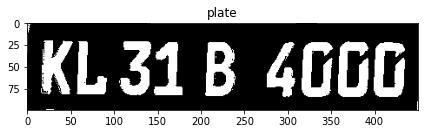

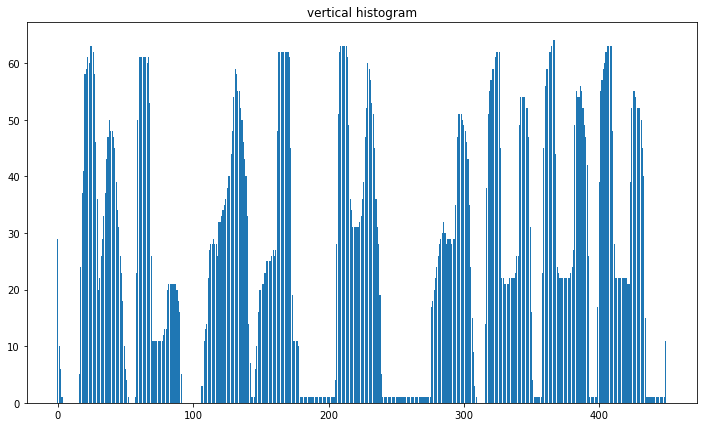

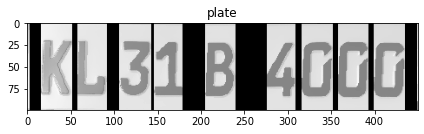

append cut at 0
append cut at end
[0, 2, 15, 51, 57, 91, 105, 142, 145, 178, 204, 239, 275, 308, 315, 351, 357, 392, 398, 434, 448, 450]
center points:
(62.5, 33.0) (53.0, 416.0)


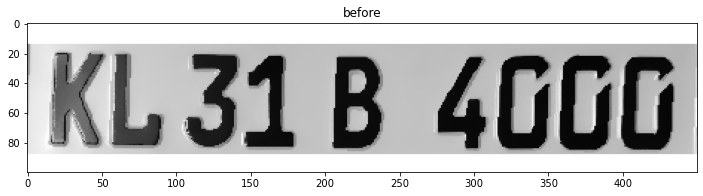

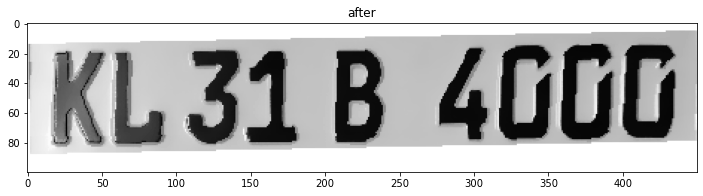

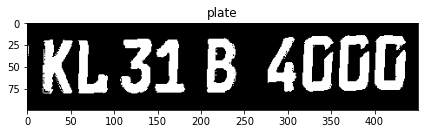

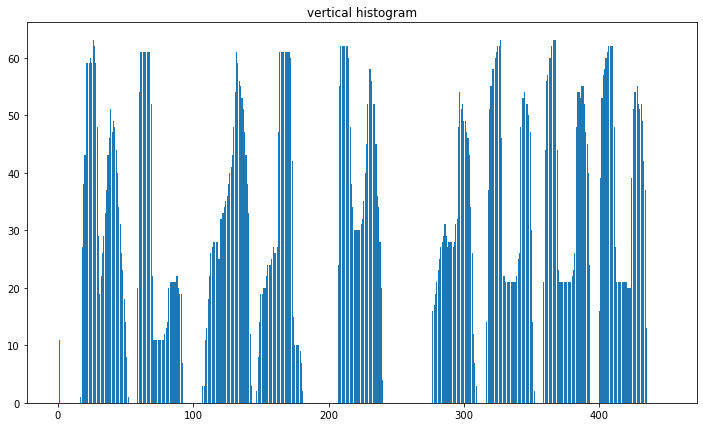

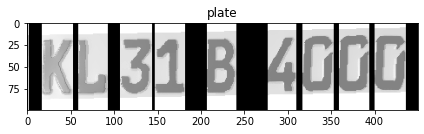

append cut at 0
[0, 1, 16, 52, 58, 92, 106, 143, 146, 181, 206, 240, 276, 309, 316, 352, 358, 393, 399, 435]


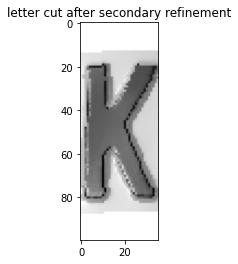

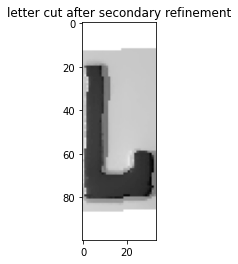

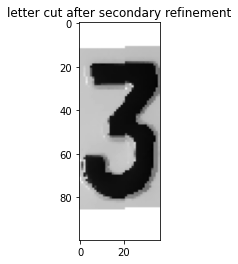

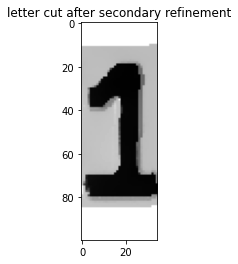

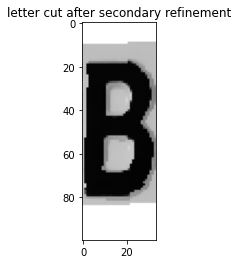

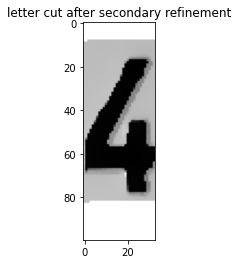

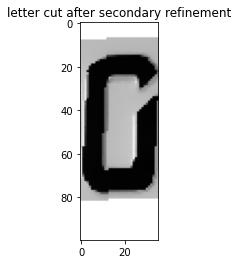

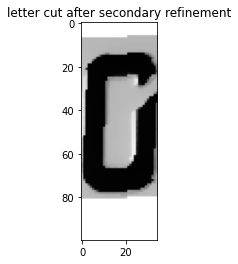

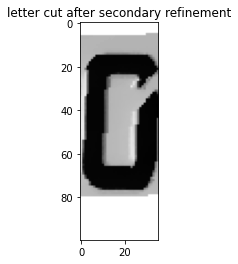

In [55]:
######################################
#
#  Running the program to cut letters out
#
######################################


# image path
img_path = 'pictures\\KL31B4000.png'

# threshold to perform binary mask
mask_threshold = 0.55

# ratio for secondary refinement 
second_refine_ratio = 0.8

# if perform side cut
sideCut = True

# if use debug mode
debug = True

#  down sample rate
# down_sample_scale = 4

letters = cutLettersWithRefinement(img_path, mask_threshold, second_refine_ratio, sideCut, debug)

final_letters = []

string = 0
for item in letters:
    
    if item.shape[1]<= 0:
        continue
    else:
        final_letters.append(item)
        
    string += 1
    # cv2.imwrite("out/"+str(string) + ".png", item * 255)
    plt.title('letter cut after secondary refinement')
    plt.imshow(item, cmap='gray')
    plt.show()

handling  0
handling  1
handling  2
handling  3
handling  4
handling  5
handling  6
handling  7
handling  8
matching result for each letter:
['K', 'L', '3', '1', 'B', '4', '0', '0', '0']
final result:
KL31B4000


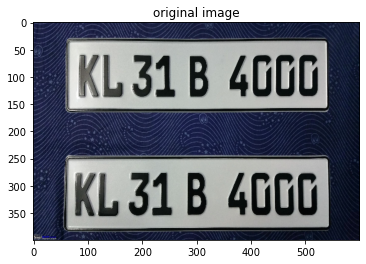

In [56]:
####################################################
#
#  Running the program to perform template matching
#
####################################################

# threshold for making cut letteres binary
# default is same as mask_threshold in cut.py, but you can change it
# decrease it if there are areas that you don't want to take into consideration
# increase it if parts of letters are lost
binary_letters_threshold =  mask_threshold

# down sample scale
# increase to get faster performance
# decrease to get better result
# default = 4, must be an integer
down_sample_scale = 4

# penalty for one pixel if letter doesn't match the template
# default = 0.2
penalty = 0.2

final_binary_letters = readCutLetters(final_letters, down_sample_scale, binary_letters_threshold)
template_letters, templates = readtemplates(down_sample_scale, penalty)
results = matching(template_letters, templates, final_binary_letters)

print("==========\nmatching result for each letter:")
print(results)
print("==========\nfinal result:")
print("".join(results))

if debug:
    img = cv2.imread(img_path,cv2.IMREAD_COLOR)
    img = cv2.resize(img, (600,400) )
    plt.title('original image')
    plt.imshow(img, cmap='gray')
    plt.show()